In [1]:
import tsflex
print(tsflex.__version__)

0.1.1.9


## Get the data

In [2]:
import pandas as pd

url = "https://github.com/predict-idlab/tsflex/raw/main/examples/data/empatica/"
df_tmp = pd.read_parquet(url+"tmp.parquet").set_index("timestamp")
df_acc = pd.read_parquet(url+"acc.parquet").set_index("timestamp")
df_gsr = pd.read_parquet(url+"gsr.parquet").set_index("timestamp")
df_ibi = pd.read_parquet(url+"ibi.parquet").set_index("timestamp")

In [3]:
from pandas.tseries.frequencies import to_offset

data = [df_tmp, df_acc, df_gsr, df_ibi]
for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Sampling rate: 4.0 Hz

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Sampling rate: 32.0 Hz

Time-series: ['EDA']
(30204, 1)
Sampling rate: 4.0 Hz

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data]
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer='iframe')

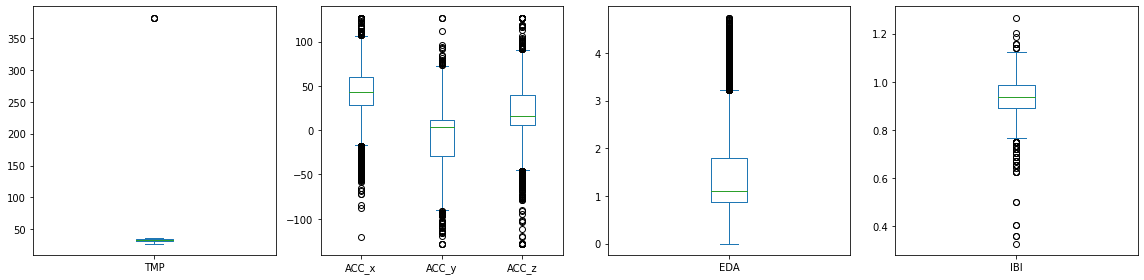

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of notebook containing the example code of the paper.

In [6]:
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Import / create the processing functions
import numpy as np
from scipy.signal import savgol_filter

def clip_quantiles(sig: pd.Series, lower_q=0.01, upper_q=0.99) -> np.ndarray:
    # Note that this function induces a data leakage
    quantile_vals = np.quantile(sig, q=[lower_q, upper_q])
    return np.clip(sig, *quantile_vals)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
clipper_tmp = SeriesProcessor(clip_quantiles, series_names="TMP", lower_q=0, upper_q=0.999)
savgol_eda = SeriesProcessor(savgol_filter, "EDA", window_length=5, polyorder=2)
savgol_acc = SeriesProcessor(savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2)
smv_processor = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline
series_pipe = SeriesPipeline(
    processors=[clipper_tmp, savgol_eda, savgol_acc, smv_processor]
)
series_pipe

[
	clip_quantiles {'lower_q': 0, 'upper_q': 0.999} :  ('TMP',)
	savgol_filter {'window_length': 5, 'polyorder': 2} :  ('EDA',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [7]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

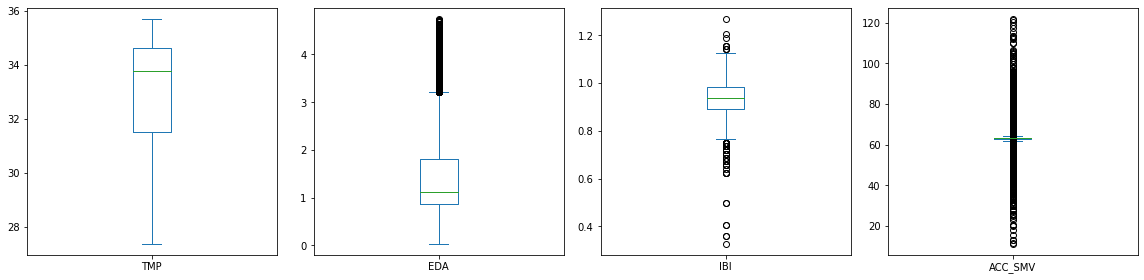

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction with [tsfresh](https://github.com/blue-yonder/tsfresh) integration

In [9]:
!pip install tsfresh

You should consider upgrading via the '/users/jonvdrdo/.venvs/venv37/bin/python3.7 -m pip install --upgrade pip' command.


[tsfresh feature-funtions](https://github.com/blue-yonder/tsfresh/blob/main/tsfresh/feature_extraction/feature_calculators.py) are either of type `simple` or `combiner`.
* `simple`: feature calculators which calculate a single number  
  **=> integrates natively with tsflex**
* `combiner`: feature calculates which calculate a bunch of features for a list of parameters. These features are returned as a list of (key, value) pairs for each input parameter.  
  **=> requires wrapping the function to only extract the values of the returned tuples**  
  
Of course, feature functions that require other keyword arguments, should be wrapped in a `FuncWrapper`

In [10]:
# This wrappers handles tsfresh its combiner functions
from tsflex.features.integrations import tsfresh_combiner_wrapper

## Using simple tsfresh features

Integrates natively :)

In [11]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection, FuncWrapper

# Import some simple funtions
from tsfresh.feature_extraction.feature_calculators import abs_energy, absolute_sum_of_changes, variance_larger_than_standard_deviation, cid_ce

general_feats = MultipleFeatureDescriptors(
        functions=[abs_energy, absolute_sum_of_changes, variance_larger_than_standard_deviation, FuncWrapper(cid_ce, normalize=True)],
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides="2min",
    )
feature_collection = FeatureCollection(general_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(absolute_sum_of_changes, ['absolute_sum_of_changes'], {}),
		FeatureDescriptor - func: FuncWrapper(variance_larger_than_standard_deviation, ['variance_larger_than_standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(cid_ce, ['cid_ce'], {'normalize': True}),
	]
	win: 2m30s , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(absolute_sum_of_changes, ['absolute_sum_of_changes'], {}),
		FeatureDescriptor - func: FuncWrapper(variance_larger_than_standard_deviation, ['variance_larger_than_standard_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper(cid_ce, ['cid_ce'], {'normalize': True}),
	]
)
EDA: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(absolut

In [12]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__absolute_sum_of_changes__w=2m30s_s=2m,EDA__abs_energy__w=5m_s=2m,ACC_SMV__absolute_sum_of_changes__w=5m_s=2m,EDA__absolute_sum_of_changes__w=5m_s=2m,ACC_SMV__variance_larger_than_standard_deviation__w=2m30s_s=2m,EDA__abs_energy__w=2m30s_s=2m,ACC_SMV__variance_larger_than_standard_deviation__w=5m_s=2m,EDA__absolute_sum_of_changes__w=2m30s_s=2m,...,TMP__absolute_sum_of_changes__w=5m_s=2m,EDA__cid_ce__w=2m30s_s=2m,EDA__cid_ce__w=5m_s=2m,TMP__abs_energy__w=2m30s_s=2m,TMP__abs_energy__w=5m_s=2m,TMP__variance_larger_than_standard_deviation__w=5m_s=2m,TMP__absolute_sum_of_changes__w=2m30s_s=2m,TMP__variance_larger_than_standard_deviation__w=2m30s_s=2m,TMP__cid_ce__w=2m30s_s=2m,TMP__cid_ce__w=5m_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,1.908184e+07,845.268541,NaN,NaN,NaN,True,184.250092,NaN,1.736521,...,NaN,5.511241,NaN,465216.34375,NaN,NaN,10.389996,False,10.732648,NaN
2017-06-13 14:26:43+02:00,NaN,1.919667e+07,1574.566142,NaN,NaN,NaN,True,289.237640,NaN,7.916409,...,NaN,6.109140,NaN,504830.37500,NaN,NaN,2.139997,False,0.638482,NaN
2017-06-13 14:27:13+02:00,3.833208e+07,NaN,NaN,522.025757,2440.009509,9.694985,NaN,NaN,True,NaN,...,12.549994,NaN,6.080983,NaN,978710.875,False,NaN,NaN,NaN,8.863720
2017-06-13 14:28:43+02:00,NaN,1.900028e+07,481.406374,NaN,NaN,NaN,True,455.579346,NaN,2.725429,...,NaN,3.939107,NaN,538692.06250,NaN,NaN,2.180008,False,0.710819,NaN
2017-06-13 14:29:13+02:00,3.821475e+07,NaN,NaN,724.489075,2126.336744,11.101377,NaN,NaN,True,NaN,...,4.400007,NaN,5.895875,NaN,1048903.250,False,NaN,NaN,NaN,0.546809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,3.815810e+07,NaN,NaN,818.431396,505.659693,2.052273,NaN,NaN,False,NaN,...,4.399990,NaN,1.291382,NaN,1109714.375,False,NaN,NaN,NaN,0.719703
2017-06-13 16:24:43+02:00,NaN,1.910876e+07,948.203277,NaN,NaN,NaN,True,409.383636,NaN,2.822474,...,NaN,1.692523,NaN,574609.37500,NaN,NaN,1.899998,False,4.435842,NaN
2017-06-13 16:25:13+02:00,3.820289e+07,NaN,NaN,861.155273,1469.749979,4.397668,NaN,NaN,True,NaN,...,4.079985,NaN,2.154354,NaN,1141974.500,False,NaN,NaN,NaN,1.619698


### Plot the EDA features

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features']
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using combiner tsfresh features

In [14]:
# Import all combiner funcs
from tsfresh.feature_extraction.feature_calculators import (
    agg_autocorrelation,
    augmented_dickey_fuller,
    cwt_coefficients,
    fft_aggregated,
    fft_coefficient,
    index_mass_quantile,
    linear_trend,
    partial_autocorrelation,
    spkt_welch_density,
    symmetry_looking,
    ar_coefficient,
    friedrich_coefficients,
    agg_linear_trend,
    energy_ratio_by_chunks,
    linear_trend_timewise,
    matrix_profile,
    query_similarity_count,
)

Calculate the features for some of tsfresh its combiner functions.  
Note that;
* `param` is now passed to `tsfresh_combiner_wrapper` instead of the combiner function itself
* combiner functions that require a `pd.Series` (with a `pd.DatetimeIndex`) are also handled by this wrapper

In [15]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection

combiner_feats = MultipleFeatureDescriptors(
        functions=[
            tsfresh_combiner_wrapper(index_mass_quantile, param=[{"q": v} for v in [0.15, 0.5, 0.75]]),
            tsfresh_combiner_wrapper(linear_trend, param=[{"attr": v} for v in ["intercept", "slope", "stderr"]]),
            tsfresh_combiner_wrapper(spkt_welch_density, param=[{"coeff": v} for v in range(5)]),
            # This function requires a pd.Series with a pd.DatetimeIndex
            tsfresh_combiner_wrapper(linear_trend_timewise, param=[{"attr": v} for v in ["intercept", "slope"]]),
        ],
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides=["2.5min"],
    )
feature_collection = FeatureCollection(combiner_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__index_mass_quantile, ["index_mass_quantile_{'q': 0.15}", "index_mass_quantile_{'q': 0.5}", "index_mass_quantile_{'q': 0.75}"], {}),
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__linear_trend, ["linear_trend_{'attr': 'intercept'}", "linear_trend_{'attr': 'slope'}", "linear_trend_{'attr': 'stderr'}"], {}),
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__spkt_welch_density, ["spkt_welch_density_{'coeff': 0}", "spkt_welch_density_{'coeff': 1}", "spkt_welch_density_{'coeff': 2}", "spkt_welch_density_{'coeff': 3}", "spkt_welch_density_{'coeff': 4}"], {}),
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__linear_trend_timewise, ["linear_trend_timewise_{'attr': 'intercept'}", "linear_trend_timewise_{'attr': 'slope'}"], {}),
	]
	win: 2m30s , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__in

In [16]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__index_mass_quantile_{'q': 0.15}__w=5m_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.5}__w=5m_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.75}__w=5m_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.15}__w=2m30s_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.5}__w=2m30s_s=2m30s,ACC_SMV__index_mass_quantile_{'q': 0.75}__w=2m30s_s=2m30s,TMP__index_mass_quantile_{'q': 0.15}__w=2m30s_s=2m30s,TMP__index_mass_quantile_{'q': 0.5}__w=2m30s_s=2m30s,TMP__index_mass_quantile_{'q': 0.75}__w=2m30s_s=2m30s,EDA__index_mass_quantile_{'q': 0.15}__w=5m_s=2m30s,...,ACC_SMV__linear_trend_{'attr': 'slope'}__w=5m_s=2m30s,ACC_SMV__linear_trend_{'attr': 'stderr'}__w=5m_s=2m30s,EDA__linear_trend_timewise_{'attr': 'intercept'}__w=2m30s_s=2m30s,EDA__linear_trend_timewise_{'attr': 'slope'}__w=2m30s_s=2m30s,EDA__linear_trend_timewise_{'attr': 'intercept'}__w=5m_s=2m30s,EDA__linear_trend_timewise_{'attr': 'slope'}__w=5m_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'intercept'}__w=5m_s=2m30s,ACC_SMV__linear_trend_timewise_{'attr': 'slope'}__w=5m_s=2m30s,TMP__linear_trend_timewise_{'attr': 'intercept'}__w=2m30s_s=2m30s,TMP__linear_trend_timewise_{'attr': 'slope'}__w=2m30s_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,NaN,NaN,0.149583,0.498333,0.749167,0.150000,0.506667,0.755000,NaN,...,NaN,NaN,0.467687,3.967294,NaN,NaN,NaN,NaN,27.382699,21.753076
2017-06-13 14:27:13+02:00,0.149896,0.501146,0.750000,0.148750,0.498958,0.748958,0.153333,0.505000,0.753333,0.192500,...,-7.667800e-06,1.169742e-05,0.559273,8.469051,0.439294,4.888440,63.146538,-0.883331,28.743725,24.482889
2017-06-13 14:29:43+02:00,0.148542,0.498750,0.749375,0.150208,0.500000,0.750000,0.151667,0.501667,0.751667,0.183333,...,-7.722570e-05,9.075504e-06,0.884233,-2.351229,0.678665,2.563162,63.452392,-8.896401,30.150985,4.119556
2017-06-13 14:32:13+02:00,0.149896,0.499271,0.749271,0.149792,0.499167,0.748958,0.153333,0.505000,0.755000,0.134167,...,-4.243882e-05,6.122260e-06,0.743566,-1.336056,0.884333,-2.612861,63.028674,-4.888952,30.296854,26.717133
2017-06-13 14:34:43+02:00,0.149688,0.499688,0.750313,0.150417,0.501042,0.751250,0.153333,0.505000,0.753333,0.152500,...,-1.442763e-05,6.261009e-06,0.733025,3.559337,0.681446,1.920888,62.753758,-1.662063,31.712060,29.547285
2017-06-13 14:37:13+02:00,0.150833,0.501771,0.751667,0.150625,0.501667,0.750833,0.150000,0.500000,0.750000,0.163333,...,9.412942e-05,1.714823e-05,0.791990,2.450926,0.766822,1.397680,62.401155,10.843709,32.883319,-2.698108
2017-06-13 14:39:43+02:00,0.150000,0.498854,0.749479,0.149167,0.500208,0.750000,0.151667,0.503333,0.753333,0.156667,...,-2.955504e-05,1.827046e-05,0.862853,2.354020,0.800792,1.839877,63.070099,-3.404741,32.299627,16.336348
2017-06-13 14:42:13+02:00,0.150000,0.498854,0.749792,0.150000,0.500625,0.750417,0.151667,0.505000,0.753333,0.158333,...,-4.217031e-05,7.484031e-06,1.029658,-3.377105,0.905266,0.729016,62.842604,-4.858020,32.650243,21.941618
2017-06-13 14:44:43+02:00,0.150833,0.502396,0.752188,0.150625,0.501875,0.750625,0.150000,0.500000,0.750000,0.131667,...,1.165610e-04,4.444229e-06,0.809848,-0.594263,1.020467,-3.411172,62.232732,13.427822,33.967144,-7.363225


### Plot the EDA features

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features']
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')